# Seminar 10. Clustering Hands-on practice

## Similar password detection
In this assignment we will try to detect similar patterns in passwords that people use all over the internet.

The input data is a collection of leaked passwords and it can be downloaded from here https://github.com/ignis-sec/Pwdb-Public/tree/master/wordlists

The task is to try to describe the data in terms of clustering: what are the groups of passwords that look quite similar or have similar logic behind them?

This seminar should be considered as a research: there are no correct answers, no points and no deadlines - just your time and your experiments with clustering algorithms.

We suggest to start with the following steps:
- download the data
- check if your favourite password is in the database
- build a distance matrix using Levenstein distance
- apply DBSCAN
- apply Agglomerative clustering and examine the dendrogram
- experiment with hyperparameters and the distance function
- look for more dependencies and password patterns


In [1]:
import numpy as np
import re

from pylev import levenshtein
from sklearn.cluster import DBSCAN, KMeans

import matplotlib.pyplot as plt

In [2]:
words_1M = []
with open("data/ignis-1M.txt", "r") as file:
    for line in file:
        words_1M.append(line.strip())

In [4]:
words_1K = []
with open("data/ignis-1K.txt", "r") as file:
    for line in file:
        words_1K.append(line.strip())

In [5]:
words = np.array(words_1M[:1000]).reshape((-1, 1))

Introduce a distance-matrix:

In [6]:
import numpy as np
from pylev import levenshtein

In [7]:
X = np.zeros((words.shape[0], words.shape[0]))

In [8]:
for i,x in enumerate(words[:, 0]):
    for j,y in enumerate(words[i:, 0]):
        X[i, i + j] = levenshtein(x, y)
        X[i + j, i] = X[i, i + j]

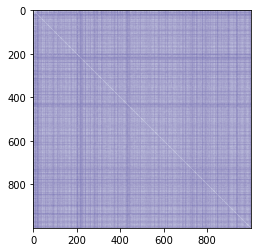

In [9]:
plt.imshow(X, cmap="Purples")
plt.show()

In [9]:
eps = 2.0
min_samples = 4

In [10]:
db = DBSCAN(eps=eps, metric="precomputed", min_samples=min_samples).fit(X)
labels = db.labels_
len(set(labels))

24

In [11]:
clusters = {}
sizes = {}
for label in set(labels):
    cluster = words[labels == label, 0]
    sizes[label] = len(cluster)
    clusters[label] = cluster
    
sizes_list = np.array(sorted([(x, y) for x,y in sizes.items()], key=lambda x: x[1], reverse=True))

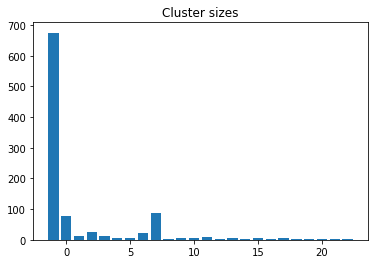

In [12]:
plt.title("Cluster sizes")
plt.bar(sizes_list[:, 0], sizes_list[:, 1])
plt.show()

In [13]:
n_top_clusters_to_plot = 1

sizes_to_plot = sizes_list[n_top_clusters_to_plot:, ]
sizes_to_plot = sizes_to_plot[sizes_to_plot[:, 1] > min_samples]

print("{} clusters cover {} passwords from {}".format(
    sizes_to_plot.shape[0],
    sum(sizes_to_plot[:, 1]),
    words.shape[0]
))

14 clusters cover 292 passwords from 1000


In [14]:
for x in sizes_to_plot:
    print(x[1], clusters[x[0]][:8])

86 ['daniel' 'master' 'charlie' 'hunter' 'tigger' 'buster' 'matrix' 'martin']
79 ['123456' '123456789' '12345678' '12345' '123123' '111111' '1234'
 '1234567890']
25 ['qwerty' 'qwertyuiop' 'qwerty123' 'azerty' 'qwe123' 'qwer1234' 'qwerty1'
 'qwertyui']
23 ['monkey' 'summer' 'chicken' 'mickey' 'hockey' 'smokey' 'fucker' 'money']
14 ['iloveyou' 'lovely' 'love' 'iloveu' 'loveme' 'lovers' 'loveyou'
 'iloveyou1']
12 ['password' 'password1' 'Password' 'passw0rd' 'Password1' 'password123'
 '<password>' 'passwort']
10 ['justin' 'jasmine' 'austin' 'jackson' 'samson' 'jasmin' 'admin' 'jason']
7 ['654321' '987654321' '0987654321' '87654321' '54321' '9876543210'
 '7654321']
7 ['159753' '159357' '159951' '753951' '951753' '159753qq' '159159']
6 ['asdfgh' 'asdf' 'asdfghjk' 'pass' 'asdfg' 'asd']
6 ['andrew' 'andrea' 'sandra' 'audrey' 'andreas' 'andrei']
6 ['hello' 'yellow' 'hello123' 'hello1' 'hallo' 'willow']
6 ['christian' 'christine' 'cristina' 'krishna' 'christina' 'kristina']
5 ['lollol' 'loulou'

In [15]:
from scipy.cluster import hierarchy

In [16]:
from scipy.spatial.distance import pdist

In [17]:
condensed_X = pdist(X)

In [18]:
linkage = hierarchy.linkage(condensed_X, method="complete")

In [19]:
linkage.shape

(999, 4)

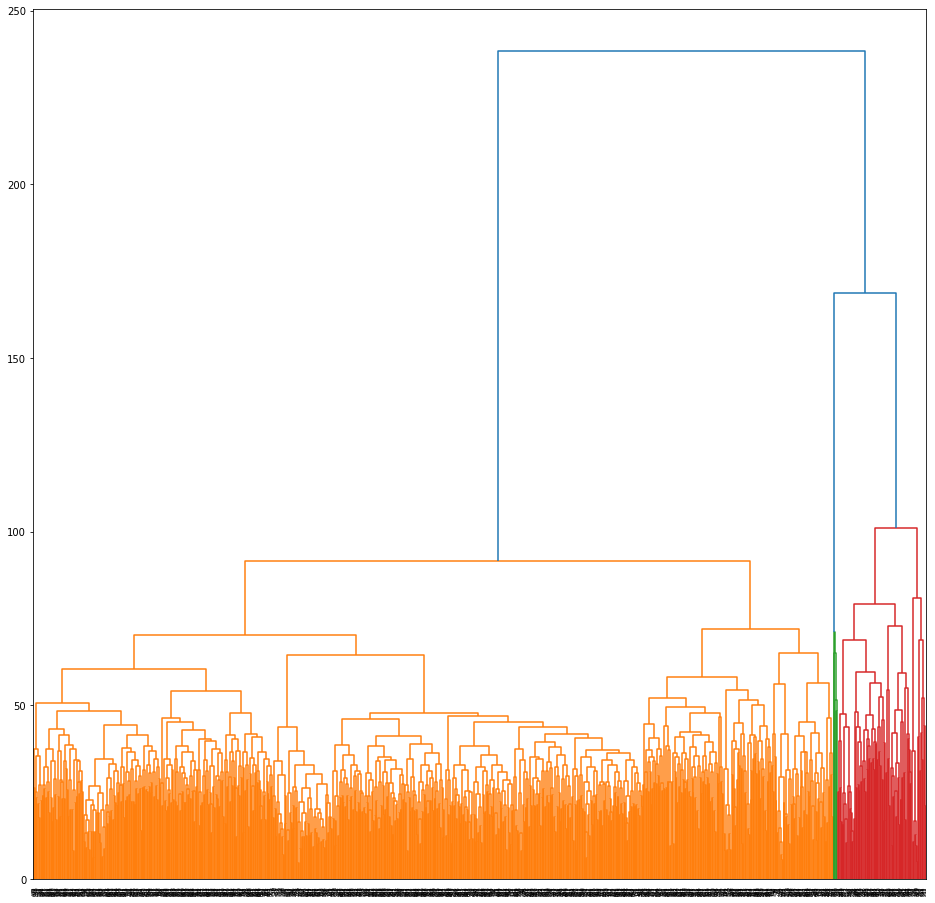

In [20]:
plt.figure(figsize=(16, 16))
dn = hierarchy.dendrogram(linkage)
plt.show()

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete')

In [23]:
Y = cluster.fit_predict(X)

In [24]:
from collections import Counter

In [25]:
Counter(Y)

Counter({4: 43, 3: 935, 0: 13, 2: 5, 1: 4})

In [26]:
words[Y == 4][:10]

array([['123456'],
       ['123456789'],
       ['12345678'],
       ['12345'],
       ['123123'],
       ['1234567890'],
       ['123321'],
       ['123qwe'],
       ['123123123'],
       ['1234qwer']], dtype='<U15')

In [27]:
# !pip3 install -U strsimpy

In [28]:
from strsimpy.weighted_levenshtein import WeightedLevenshtein


def insertion_cost(char):
    return 1.0


def deletion_cost(char):
    return 1.0


def substitution_cost(char_a, char_b):
    if char_a == 't' and char_b == 'r':
        return 0.5
    return 1.0

weighted_levenshtein = WeightedLevenshtein(
    substitution_cost_fn=substitution_cost,
    insertion_cost_fn=insertion_cost,
    deletion_cost_fn=deletion_cost)


In [29]:
print(weighted_levenshtein.distance('Stting1', 'String1'))

0.5


In [30]:
print(weighted_levenshtein.distance('String1', 'Stting1'))

1.0


### Kmeans and embeddings

In [31]:
import gensim.downloader

In [32]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [33]:
word_embeddings = gensim.downloader.load("glove-wiki-gigaword-100")

In [34]:
part_word_emb_names = []
part_word_emb_values = []

for word in words[:, 0]:
    if word in word_embeddings:
        part_word_emb_names.append(word)
        part_word_emb_values.append(word_embeddings[word])

In [35]:
len(words), len(part_word_emb_names)

(1000, 621)

In [36]:
part_word_emb_names[:25]

['123456789',
 'password',
 'qwerty',
 '12345',
 '1234',
 'iloveyou',
 '123',
 '000000',
 'dragon',
 'ashley',
 'princess',
 'monkey',
 'pokemon',
 'football',
 'killer',
 'michael',
 'shadow',
 'daniel',
 'superman',
 'azerty',
 'master',
 'sunshine',
 'computer',
 'baseball',
 'charlie']

In [37]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=2)
pca_words = pca.fit_transform(part_word_emb_values)

In [39]:
pca_words.shape

(621, 2)

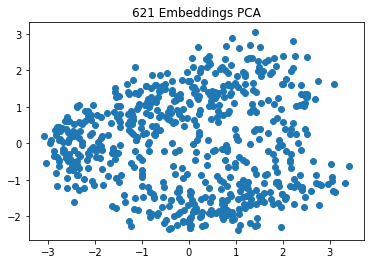

In [40]:
plt.scatter(pca_words[:, 0], pca_words[:, 1])
plt.title("621 Embeddings PCA")
plt.show()

In [41]:
embeddings_clusters = KMeans(n_clusters=3).fit_predict(part_word_emb_values)

In [42]:
Counter(embeddings_clusters)

Counter({2: 220, 0: 191, 1: 210})

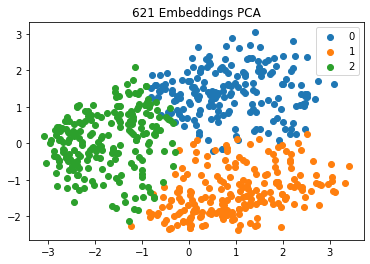

In [43]:
for i in range(len(set(embeddings_clusters))):
    plt.scatter(pca_words[embeddings_clusters == i, 0], pca_words[embeddings_clusters == i, 1], label=i)
plt.legend()
plt.title("621 Embeddings PCA")
plt.show()

In [44]:
for i in range(len(set(embeddings_clusters))):
    print(i)
    for word in np.array(part_word_emb_names)[embeddings_clusters == i][:5]:
        print(word)
    print("---")

0
dragon
football
killer
shadow
master
---
1
ashley
princess
michael
daniel
charlie
---
2
123456789
password
qwerty
12345
1234
---
